# PROJETO - PREDISÃO DE PREÇO DE CASAS

### Objetivo:
Criar um modelo de Machine Learning para prever o preço de uma casa e Identificar quais variáveis de uma casa mais influenciam o preço (e o peso de cada uma) usando técnicas de Machine Learning interpretável e análise estatística.

##### Importação de bibliotecas

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler

##### Lendo os Datasets

In [7]:
test_df = pd.read_csv('test.csv')
df = pd.read_csv('train.csv')

###  Análise Exploratória de Dados (EDA)
Estou conduzindo a Análise Exploratória de Dados (EDA) para entender melhor as características do nosso dataset. O primeiro passo é inspecionar a estrutura dos dados, incluindo o tipo das variáveis e a presença de valores nulos. 

#### EDA 1. Descrição das Variáveis do Dataset:
A seguir, apresento uma lista das variáveis presentes no dataset com seus respectivos valores e descrições:

In [8]:
with open('data_description.txt', 'r', encoding='utf-8') as file:
    variaveis = file.read()

print(variaveis)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

#### EDA 2. Verificando valores nulos:

In [9]:
df.isnull().sum()[df.isnull().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

> Durante a análise do conjunto de dados, das variáveis que apresentavam valores nulos foi possível identificar apenas duas que precisavam de correção.

In [10]:
df['LotFrontage'] = df['LotFrontage'].fillna(0)
df['Electrical'] = df['Electrical'].fillna('SBrkr')

**LotFrontage**: que representa a largura da frente do lote, apresentou valores ausentes (NaN). Como é uma variável numérica e, após análise, concluímos que a substituição por um valor fixo seria a melhor abordagem, optei por substituir os valores nulos por 0, considerando que a ausência de informações sobre a largura da frente do lote pode ser tratada como a ausência de lote.

**Electrical**: Esta variável, que representa o tipo de sistema elétrico da casa, também apresentou valores ausentes. Para variáveis categóricas como esta, a melhor prática é substituir os valores nulos pelo valor mais frequente da coluna, ou seja, a moda. Nesse caso, a moda foi "SBrkr" (que se refere ao sistema elétrico "Standard Circuit Breaker Panel"), portanto, todos os valores nulos nesta coluna foram substituídos por "SBrkr".

O próximo passo após a correção dos valores nulos é a análise das distribuições das variáveis e a detecção de outliers.

#### EDA 3. Mapa de Calor - Correlação Geral das Variáveis
Nesta etapa, foi gerado um mapa de calor (heatmap) para visualizar a correlação entre todas as variáveis numéricas do conjunto de dados. O objetivo deste gráfico é identificar como cada variável se relaciona com as demais, além de observar possíveis padrões e variáveis altamente correlacionadas. Esta visão geral ajuda na detecção de colinearidade e fornece um panorama completo da estrutura do dataset.

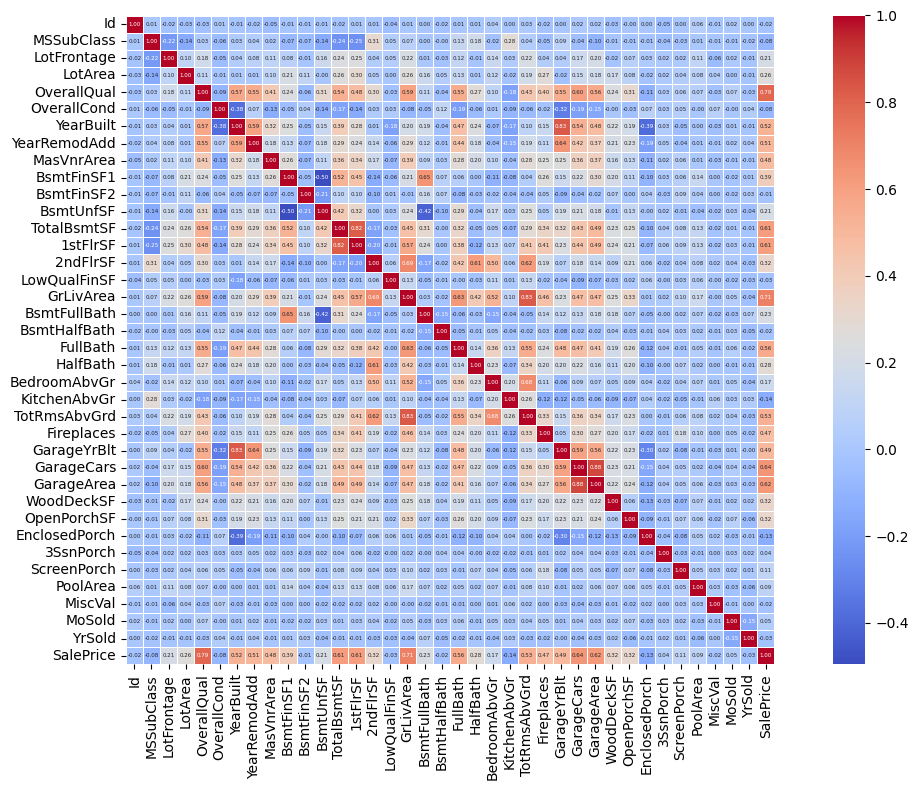

In [22]:
num_df = df.select_dtypes(include=['float64', 'int64'])

# Calcula a matriz de correlação
corr = num_df.corr()

# Faz o heatmap
plt.figure(figsize=(12, 8))  
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 4}, linewidths=0.5, square=True)

# Exibindo o gráfico
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

#### EDA 4. Mapa de Calor - 10 Variáveis mais Correlacionadas com o target (SalePrice)
Após a análise geral, foi realizada uma filtragem para selecionar as 10 variáveis mais correlacionadas com a variável alvo SalePrice. Esse segundo heatmap apresenta a correlação entre essas variáveis e o SalePrice, além das correlações entre elas mesmas. O objetivo é destacar os principais fatores que possuem maior impacto no preço de venda das casas, auxiliando na seleção de variáveis mais relevantes para a construção dos modelos preditivos.

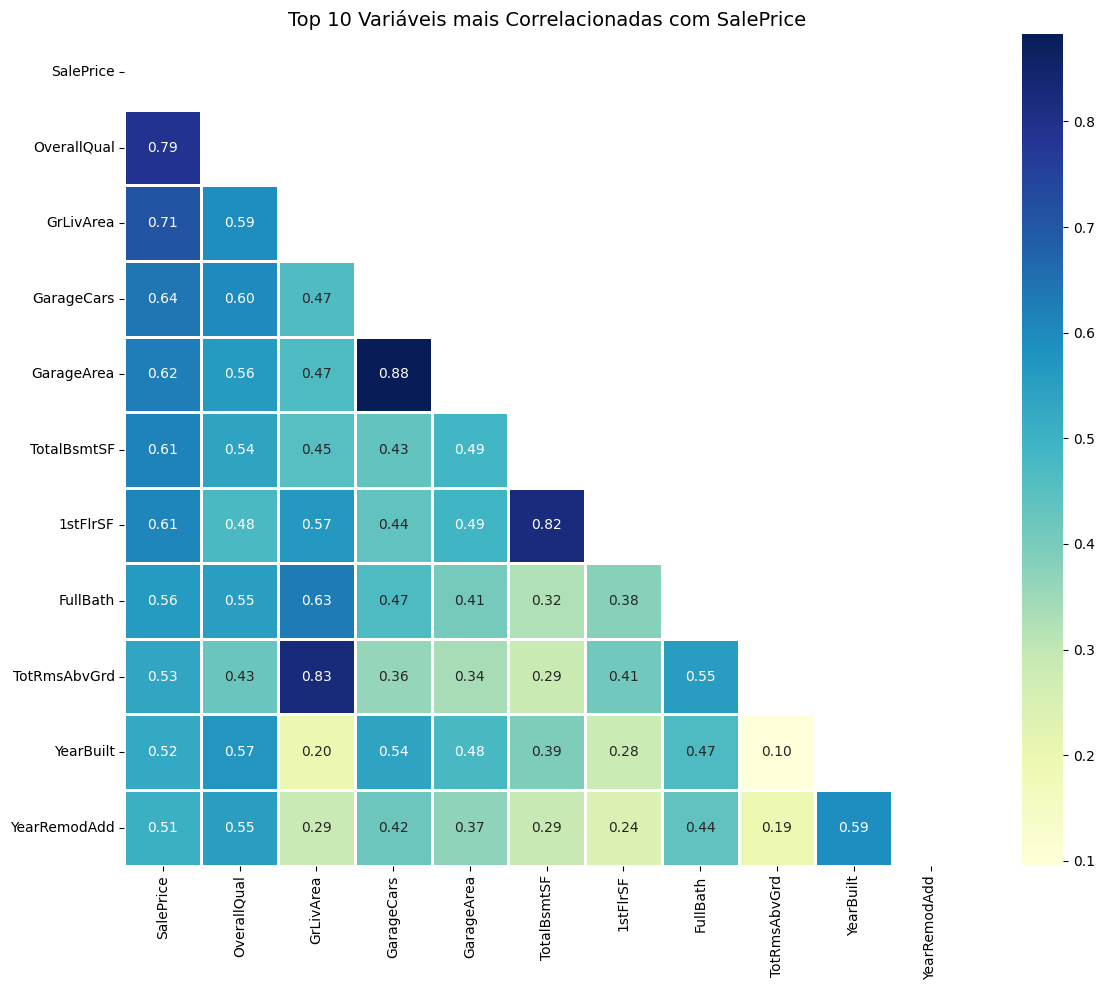

In [37]:
# Seleciona as 10 variáveis mais correlacionadas e o SalePrice
target_corr = corr['SalePrice'].abs().sort_values(ascending=False)
top_corr_vars = target_corr.index[:11]  

# Filtra a matriz de correlação só para as variáveis selecionadas
corr_top = corr.loc[top_corr_vars, top_corr_vars]

# Máscara para exibir apenas o triângulo inferior
mask = np.triu(np.ones_like(corr_top, dtype=bool))

# Cria o heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_top, 
    mask=mask,               # Mostra só o triângulo inferior
    annot=True,              # Mostra os valores nas células
    fmt=".2f",               # Formato das anotações
    cmap='YlGnBu',           # Paleta de cores
    linewidths=1,            # Linhas entre as células
    linecolor='white',       
    annot_kws={"size": 10}   # Tamanho do texto das anotações
)

# Título do gráfico
plt.title('Top 10 Variáveis mais Correlacionadas com SalePrice', fontsize=14)

# Ajusta o layout
plt.tight_layout()

# Exibe o gráfico
plt.show()

#### **Conclusão do EDA**

Durante a etapa de Análise Exploratória de Dados (EDA), realizamos uma série de atividades para entender as características e distribuições dos dados, identificar potenciais problemas como valores ausentes, explorar as variáveis mais relevantes para a previsão do preço de venda das casas.

Primeiramente, fizemos uma tratativa de valores ausentes, depois realizamos uma análise de correlação entre as variáveis e a variável alvo **SalePrice**, identificando as que mais influenciam o preço.

Após essa análise, selecionamos as variáveis mais impactantes, aquelas que apresentam maior correlação com o **SalePrice** e que têm um impacto significativo no preço das casas. As variáveis escolhidas para continuar a análise foram:

- **OverallQual** (qualidade geral da casa)
- **GrLivArea** (área total da sala de estar)
- **GarageCars** (número de carros que a garagem pode acomodar)
- **GarageArea** (área da garagem)
- **TotalBsmtSF** (área total do porão)
- **1stFlrSF** (área do primeiro andar)
- **TotRmsAbvGrd** (número total de quartos acima do solo)
- **YearBuilt** (ano de construção)
- **YearRemodAdd** (ano de renovação)
- **FullBath** (número de banheiros completos)

Essas variáveis foram selecionadas com base nas correlações identificadas, com o objetivo de construir um modelo de previsão do preço de venda das casas. O próximo passo será realizar o pré-processamento, que inclui o tratamento de valores ausentes, a normalização e/ou padronização das variáveis, e o treinamento do modelo, onde testaremos técnicas de Machine Learning para prever com precisão os preços das casas.

### Engenharia de Atributos
Nesta etapa do projeto, escolhi o modelo de Regressão Linear para o projeto, realizamos o pré-processamento dos dados para preparar as variáveis para o modelo. 

#### EA 1. Identificação e Tratamento de Outliers
Primeiramente, realizamos o tratamento de outliers nas variáveis selecionadas com maior correlação com o preço de venda (SalePrice). Outliers podem distorcer os resultados da Regressão Linear, impactando negativamente o desempenho do modelo. O tratamento pode incluir a remoção de registros extremos ou a aplicação de transformações como o logaritmo.

#### EA 2. Análise de Distribuição das Variáveis Numéricas:
Nessa etapa, a utilização do histograma é importante para visualizar a distribuição das variáveis numéricas do dataset. O histograma permite observar como os valores de uma variável se distribuem, identificando se a distribuição é normal, assimétrica ou possui outliers.

In [ ]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Define o número de colunas fixo (ex: 4) e calcula as linhas necessárias
num_plots = len(num_cols)
cols = 4
rows = math.ceil(num_plots / cols)  # Arredonda para cima

plt.figure(figsize=(15, rows * 4))  # Ajusta o tamanho conforme as linhas

for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, cols, i)  # Ajusta dinamicamente as linhas
    sns.histplot(df[col].dropna(), kde=True, color='skyblue', edgecolor='black')
    plt.title(col)

plt.tight_layout()
plt.show()

#### EA 3. Padronização das Variáveis

Em seguida, aplicamos a padronização (StandardScaler) nas variáveis escolhidas, ajustando os dados para que cada variável tenha média zero e desvio padrão igual a um. Essa técnica é essencial para algoritmos como a Regressão Linear, pois evita que variáveis com diferentes escalas influenciem de forma desproporcional o modelo.

Com isso, garantimos que todas as variáveis estejam na mesma escala e que os outliers não comprometam a performance do algoritmo de regressão.